In [1]:
import skimage.io
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import cv2
from skimage import exposure, color
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
def calcular_promedio_color(imagen):

    promedio_color = imagen.mean(axis=(0,1))
    std = imagen.std(axis=(0,1))

    data = {
        'intensidad_Rojo': promedio_color[0], 'contraste_Rojo': std[0],
        'intensidad_Verde': promedio_color[1], 'contraste_Verde': std[1],
        'intensidad_Azul': promedio_color[2], 'contraste_Azul': std[2]
    }

    df = pd.DataFrame(data, index=[0])

    return df

In [3]:
def media_imagen_threshold(imagen):
    img_gray = color.rgb2gray(imagen)
    img_ampliacion_rango = exposure.rescale_intensity(img_gray, in_range='image', out_range=(0, 1))
    smoothed_image = cv2.GaussianBlur(img_ampliacion_rango, (5, 5), 0)
    imagen_umbralizada_globulos_blancos = (smoothed_image > 0.25).astype(np.uint8) * 255
    imagen_umbralizada_globulos_negros = 255 - imagen_umbralizada_globulos_blancos
    media_negro = np.mean(imagen_umbralizada_globulos_negros)
    std_negro = np.std(imagen_umbralizada_globulos_negros)
    return media_negro, std_negro

In [4]:
carpeta = 'data'
lista_dfs_res = []

for subcarpeta in os.listdir(carpeta):
    ruta_subcarpeta = os.path.join(carpeta,subcarpeta)
    resultados = []

    for nombre_archivo in os.listdir(ruta_subcarpeta):
        ruta_imagen = os.path.join(ruta_subcarpeta, nombre_archivo)

        if os.path.isfile(ruta_imagen) and nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            imagen = skimage.io.imread(ruta_imagen)
            
            df_resultado = calcular_promedio_color(imagen)
            media_binario, std_binario = media_imagen_threshold(imagen) 
            df_resultado['intensidad_binario'] = media_binario
            df_resultado['contraste_binario'] = std_binario
            resultados.append(df_resultado)

    df_res = pd.concat(resultados, ignore_index=True)
    if subcarpeta == 'healthy':
        df_res['label'] = 0
    else:
        df_res['label'] = 1


    lista_dfs_res.append(df_res)

df = pd.concat([lista_dfs_res[0], lista_dfs_res[1]], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

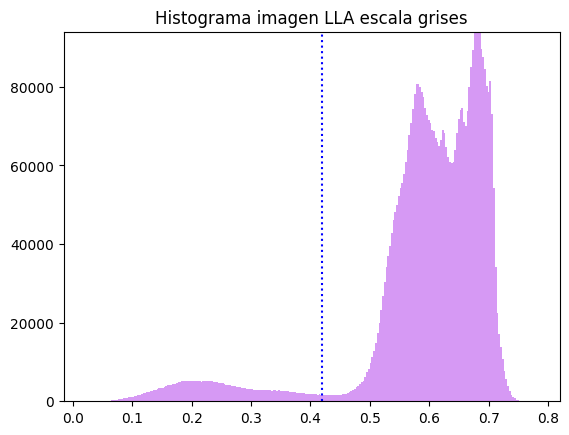

In [5]:
imagen = skimage.io.imread('data/LLA/Im063_1.jpg')
img_gray = color.rgb2gray(imagen)
img_ampliacion_rango = exposure.rescale_intensity(img_gray, in_range='image', out_range=(0, 1))
smoothed_image = cv2.GaussianBlur(img_ampliacion_rango, (5, 5), 0)
plt.hist(smoothed_image.ravel(), bins = 256, color = '#ae34eb', alpha = .5);
plt.vlines(0.42, 0, 95000, colors='blue', linestyles='dotted')
plt.ylim([0, 94000])
plt.title('Histograma imagen LLA escala grises')
plt.show()

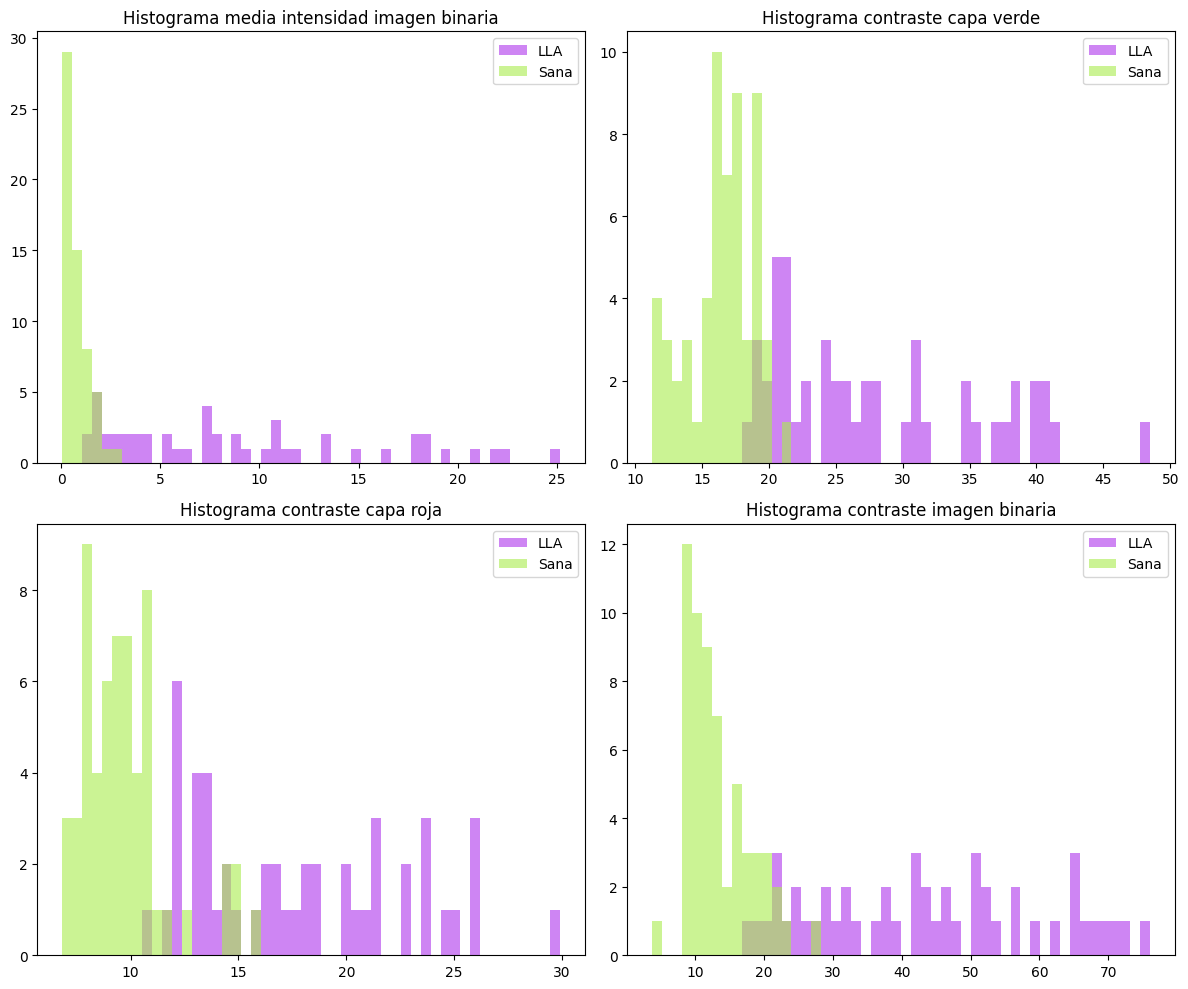

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Histograma de distribución de la media de imagen binaria
axs[0, 0].hist([df[df['label']==0]['intensidad_binario'], df[df['label']==1]['intensidad_binario']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[0, 0].set_title('Histograma media intensidad imagen binaria')
axs[0, 0].legend()

# Histograma contraste capa verde
axs[0, 1].hist([df[df['label']==0]['contraste_Verde'], df[df['label']==1]['contraste_Verde']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[0, 1].set_title('Histograma contraste capa verde')
axs[0, 1].legend()

# Histograma contraste capa roja
axs[1, 0].hist([df[df['label']==0]['contraste_Rojo'], df[df['label']==1]['contraste_Rojo']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[1, 0].set_title('Histograma contraste capa roja')
axs[1, 0].legend()

# Histograma contraste imagen binaria
axs[1, 1].hist([df[df['label']==0]['contraste_binario'], df[df['label']==1]['contraste_binario']],
               bins=50, color=['#a9eb4d', '#ae34eb'], label=['Sana', 'LLA'], histtype='stepfilled', alpha=.6)
axs[1, 1].set_title('Histograma contraste imagen binaria')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [7]:
df.to_csv('dataset_features.csv', index=False)
print(df.head())

   intensidad_Rojo  contraste_Rojo  intensidad_Verde  contraste_Verde  \
0       155.229978        8.558158        140.717721        17.890374   
1       148.268971       13.536176        133.782118        20.543855   
2       149.753560       17.956941        133.682051        26.392448   
3       158.451615       10.054871        146.086184        18.982746   
4       155.348820       29.909160        136.792533        48.480713   

   intensidad_Azul  contraste_Azul  intensidad_binario  contraste_binario  \
0       127.920689       14.412911            0.418923          10.327144   
1       124.461670        9.804720            7.327309          42.600168   
2       127.348791       11.838747           13.327302          56.752490   
3       135.494181       15.658741            0.426919          10.425070   
4       154.485384       21.317315           25.150319          76.031525   

   label  
0      0  
1      1  
2      1  
3      0  
4      1  


Precisión del modelo: 0.9444


Text(0, 0.5, 'Importancia')

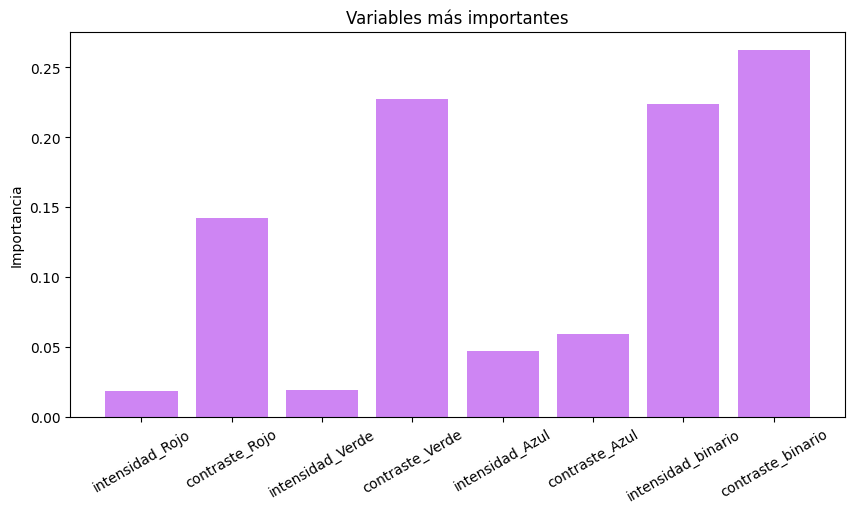

In [8]:
X = df.drop('label', axis=1)
y = df['label']

X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=0.2, random_state=42)

clasificador = RandomForestClassifier()

clasificador.fit(X_train, y_train)
pred = clasificador.predict(X_val)

accuracy = accuracy_score(y_val, pred)
print(f"Precisión del modelo: {accuracy:.4f}")

variables_importantes = pd.DataFrame({'variables': X_train.columns, 'importancia': clasificador.feature_importances_})
plt.figure(figsize=(10,5))
plt.bar(variables_importantes['variables'], variables_importantes['importancia'], color = '#ae34eb', alpha = .6)
plt.title('Variables más importantes')
plt.xticks(rotation = 30)
plt.ylabel('Importancia')

In [9]:
df = pd.read_csv('dataset_features.csv')

In [10]:
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clasificador = LogisticRegression()

clasificador.fit(X_train, y_train)
pred = clasificador.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.9545


c:\Users\unaim\Anaconda3\envs\unaimleal\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
coefs = pd.Series(clasificador.coef_[0], index=X.columns)

coefs_sorted = coefs.abs().sort_values(ascending=False)

print("Variables ordenadas por su aportación al modelo:")
print(coefs_sorted)

Variables ordenadas por su aportación al modelo:
intensidad_Azul       0.683637
contraste_binario     0.597589
intensidad_Verde      0.411967
contraste_Azul        0.406173
contraste_Verde       0.378539
intensidad_Rojo       0.181491
contraste_Rojo        0.167958
intensidad_binario    0.131559
dtype: float64


Prueba del modelo solo con las características más relevantes

In [12]:
X = df.drop('label', axis=1)
X = X[coefs_sorted.index[:4]]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clasificador = RandomForestClassifier()

clasificador.fit(X_train, y_train)
pred = clasificador.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print(f"Precisión del modelo: {accuracy:.4f}")

Precisión del modelo: 0.9545


Prueba del modelo con aplicación de validación cruzada

In [13]:
X = df.drop('label', axis=1)
y = df['label']

clasificador_lr = LogisticRegression()
scores_lr = cross_val_score(clasificador_lr, X, y, cv=5)  # cv=5 para 5 folds
print(f"Precisión de la regresión logística con validación cruzada: {scores_lr.mean():.4f}")

clasificador_rf = RandomForestClassifier()
scores_rf = cross_val_score(clasificador_rf, X, y, cv=5)  # cv=5 para 5 folds
print(f"Precisión del RandomForestClassifier con validación cruzada: {scores_rf.mean():.4f}")

Precisión de la regresión logística con validación cruzada: 0.9909


c:\Users\unaim\Anaconda3\envs\unaimleal\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\unaim\Anaconda3\envs\unaimleal\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Precisión del RandomForestClassifier con validación cruzada: 0.9632
